In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000,n_features=20,centers=3,cluster_std=1.0,random_state=0)

In [6]:
def custom_pca(X, keep_dims=None, var_threshold=None, method='eig'):
    import numpy as np
    """
    Simple PCA supporting either:
      * keep_dims=int   → keep exactly that many PCs (and report % variance explained)
      * var_threshold=0.9 → keep as many PCs as needed to reach that fraction (and report # PCs)
    Exactly one of keep_dims or var_threshold must be provided.
    One method for muse also be provided. Suport for:
      *Eigen decomposition=eig (default)
      *Singular Value Decomposition=svd
    """
    # 0. check inputs
    if (keep_dims is None) == (var_threshold is None):
        raise ValueError("Specify exactly one of keep_dims or var_threshold")

    # 1. center data
    mu = np.mean(X, axis=0)
    Xc = X - mu
    n, p = Xc.shape

    # 2. Compute factorization based on selected method
    if method == 'eig':
        # 2a. Compute covariance matrix and its eigen decomposition
        C = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eig(C)
        idx = np.argsort(eigvals)[::-1]
        eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
        loadings_all = eigvecs
    elif method == 'svd':
        # 2b. Use singular value decomposition
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        eigvals = (S**2) / (n - 1)
        loadings_all = Vt.T
    else:
        raise ValueError("method must be 'eig' or 'svd'")

    # 3. explained‐variance ratios
    var_ratios = eigvals / np.sum(eigvals)

    # 4. Select number of components based on variance threshold or fixed count
    if var_threshold is not None:
        cumvar = np.cumsum(var_ratios)
        keep_dims = np.searchsorted(cumvar, var_threshold) + 1
        print(f"► Selected {keep_dims} PCs to explain ≥{var_threshold*100:.1f}% of variance")
    else:
        explained = np.sum(var_ratios[:keep_dims])
        print(f"► Keeping {keep_dims} PCs, which explain {explained*100:.1f}% of variance")

    # 5. Ensure consistent sign of loadings for reproducibility
    for j in range(loadings_all.shape[1]):
        pc = loadings_all[:, j]
        if pc[np.argmax(np.abs(pc))] < 0:
            loadings_all[:, j] = -pc
    # 6. Project centered data onto the selected principal components
    loadings = loadings_all[:, :keep_dims]
    Z = Xc @ loadings

    return Z, loadings, var_ratios


► Selected 2 PCs to explain ≥80.0% of variance
► Keeping 2 PCs, which explain 95.8% of variance


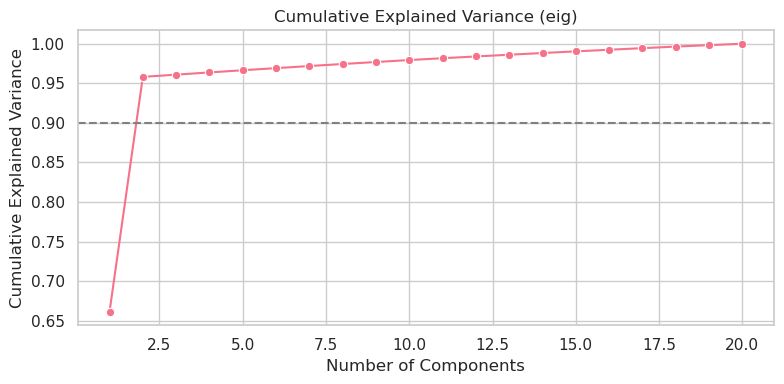

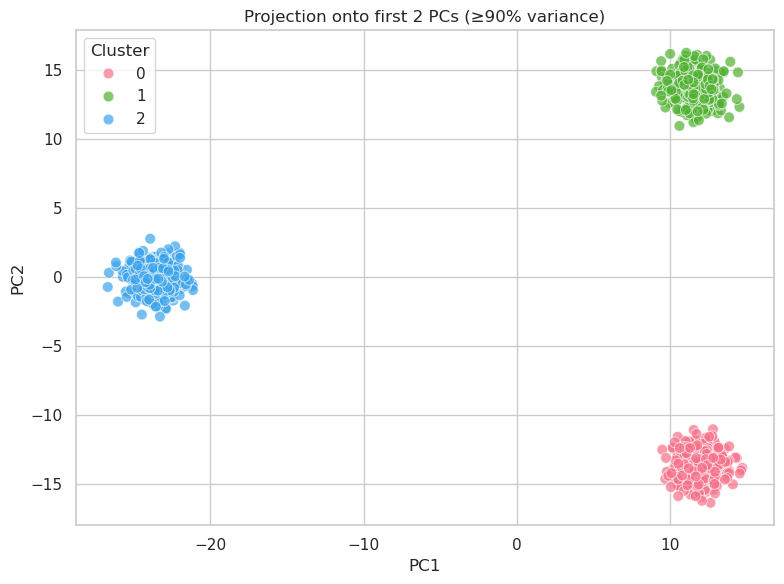

► Keeping 2 PCs, which explain 95.8% of variance
► Keeping 2 PCs, which explain 95.8% of variance


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 1) PCA to retain ≥90% variance
Z90, L90, vr90 = custom_pca(X, var_threshold=0.8, method='eig')
Z2, L2, vr2 = custom_pca(X, keep_dims=2, method='svd')
cumvar90 = np.cumsum(vr90)
dims90 = Z90.shape[1]
sns.set_theme(style="whitegrid", palette="husl")
plt.figure(figsize=(8, 4))
sns.lineplot(x=np.arange(1, len(vr90)+1), y=cumvar90, marker="o")
plt.axhline(0.9, linestyle='--', color='gray')
plt.title('Cumulative Explained Variance (eig)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z90[:,0], y=Z90[:,1], hue=y.astype(str), palette="husl", s=60, alpha=0.7)
plt.title(f'Projection onto first {Z90.shape[1]} PCs (≥90% variance)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Z2_eig, _, _ = custom_pca(X, keep_dims=2, method='eig')
Z2_svd, _, _ = custom_pca(X, keep_dims=2, method='svd')

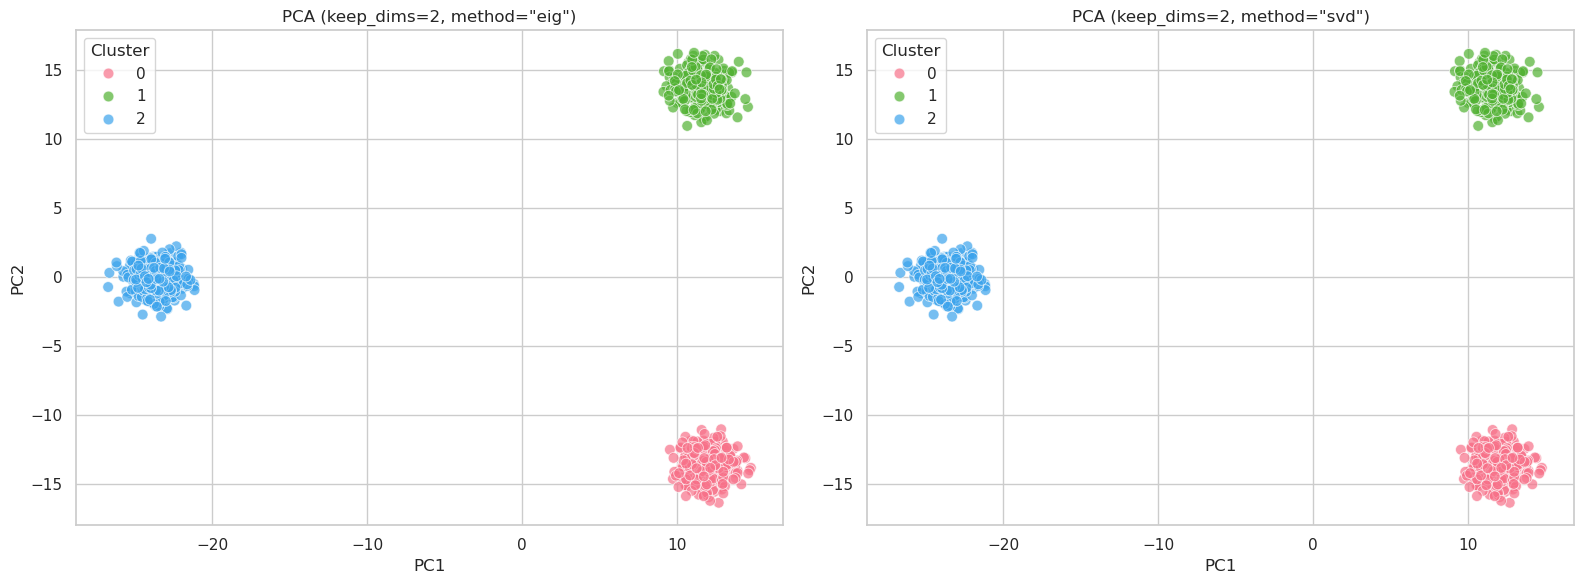

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume Z2_eig, Z2_svd, and y are already defined

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: eigen-decomposition
sns.scatterplot(
    x=Z2_eig[:, 0], y=Z2_eig[:, 1],
    hue=y.astype(str), palette="husl",
    s=60, alpha=0.7, ax=axes[0]
)
axes[0].set_title('PCA (keep_dims=2, method="eig")')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title="Cluster")

# Right: SVD
sns.scatterplot(
    x=Z2_svd[:, 0], y=Z2_svd[:, 1],
    hue=y.astype(str), palette="husl",
    s=60, alpha=0.7, ax=axes[1]
)
axes[1].set_title('PCA (keep_dims=2, method="svd")')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title="Cluster")

plt.tight_layout()
plt.show()


► Keeping 2 PCs = 96.8% var


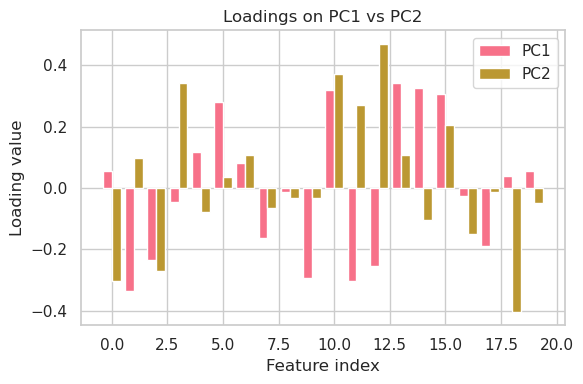

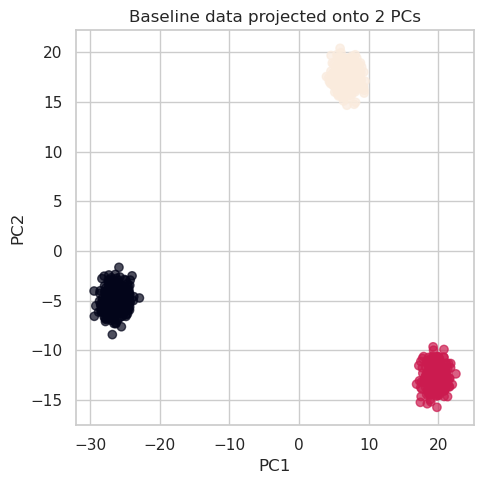

► Keeping 2 PCs = 71.6% var


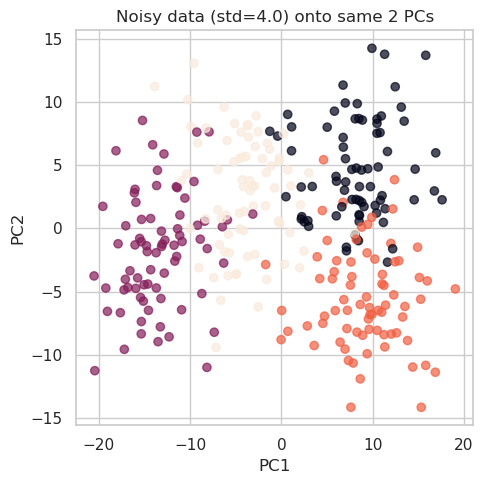

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def custom_pca(X, keep_dims=None, var_threshold=None, method='eig'):
    """
    PCA that either keeps a fixed number of components (keep_dims)
    or enough to reach var_threshold.  Use exactly one of them.
    """
    if (keep_dims is None) == (var_threshold is None):
        raise ValueError("Specify exactly one of keep_dims or var_threshold")
    # 1. center
    mu = np.mean(X, axis=0)
    Xc = X - mu
    n, p = Xc.shape

    # 2. decomposition
    if method == 'eig':
        C = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eig(C)
        idx = np.argsort(eigvals)[::-1]
        eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
        loadings_all = eigvecs
    elif method == 'svd':
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        eigvals = (S**2) / (n - 1)
        loadings_all = Vt.T
    else:
        raise ValueError("method must be 'eig' or 'svd'")

    # 3. explained variance ratios
    var_ratios = eigvals / np.sum(eigvals)

    # 4. select dims
    if var_threshold is not None:
        cumvar = np.cumsum(var_ratios)
        keep_dims = np.searchsorted(cumvar, var_threshold) + 1
        print(f"► Selected {keep_dims} PCs for ≥{var_threshold*100:.1f}% var")
    else:
        explained = np.sum(var_ratios[:keep_dims])
        print(f"► Keeping {keep_dims} PCs = {explained*100:.1f}% var")

    # 5. fix sign
    for j in range(loadings_all.shape[1]):
        pc = loadings_all[:, j]
        if pc[np.argmax(np.abs(pc))] < 0:
            loadings_all[:, j] = -pc

    # 6. project
    loadings = loadings_all[:, :keep_dims]
    Z = Xc @ loadings
    return Z, loadings, var_ratios

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000,n_features=20,centers=3,cluster_std=1.0,random_state=0)
# --- STEP 1 & 2: baseline data & PCA with 2 PCs ---
X1, y1 = make_blobs(
    n_samples=1000, centers=3, n_features=20,
    cluster_std=1.0, random_state=42
)

# force exactly 2 PCs
Z1, loadings1, _ = custom_pca(X1, keep_dims=2, method='svd')

# --- STEP 2: plot loadings of PC1 and PC2 ---
plt.figure(figsize=(6,4))
idx = np.arange(loadings1.shape[0])
plt.bar(idx - 0.2, loadings1[:,0], width=0.4, label='PC1')
plt.bar(idx + 0.2, loadings1[:,1], width=0.4, label='PC2')
plt.xlabel('Feature index'); plt.ylabel('Loading value')
plt.title('Loadings on PC1 vs PC2')
plt.legend()
plt.tight_layout()
plt.show()


# --- STEP 3: 2D projection of the baseline data ---
plt.figure(figsize=(5,5))
plt.scatter(Z1[:,0], Z1[:,1], c=y1, alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Baseline data projected onto 2 PCs')
plt.tight_layout()
plt.show()


# --- STEP 4: new data with higher cluster_std and same 2 PCs ---
X2, y2 = make_blobs(
    n_samples=300, centers=4, n_features=5,
    cluster_std=4.0, random_state=42
)

Z2, _, _ = custom_pca(X2, keep_dims=2, method='svd')

plt.figure(figsize=(5,5))
plt.scatter(Z2[:,0], Z2[:,1], c=y2, alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Noisy data (std=4.0) onto same 2 PCs')
plt.tight_layout()
plt.show()


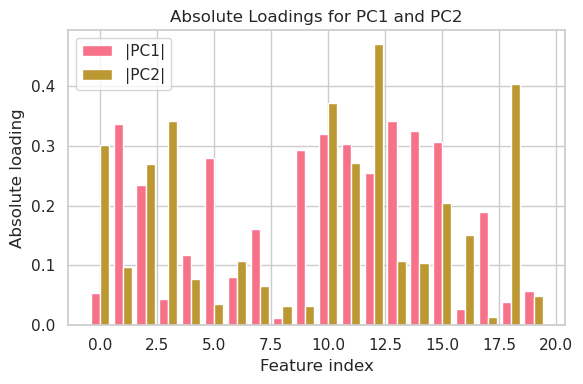

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming loadings1 is already computed from the baseline PCA
# If not, recompute with custom_pca (shown previously).

# Compute absolute loadings for PC1 and PC2
abs_loadings = np.abs(loadings1)

# Plot
idx = np.arange(abs_loadings.shape[0])
plt.figure(figsize=(6,4))
plt.bar(idx - 0.2, abs_loadings[:, 0], width=0.4, label='|PC1|')
plt.bar(idx + 0.2, abs_loadings[:, 1], width=0.4, label='|PC2|')
plt.xlabel('Feature index')
plt.ylabel('Absolute loading')
plt.title('Absolute Loadings for PC1 and PC2')
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

def custom_pca(X, keep_dims=None, var_threshold=None, method='eig'):
    """
    PCA whose 'loadings' (for interpretation) are defined
    exactly as in the lecture slides: 
      Loadings = eigenvectors * eigenvalues.

    One of keep_dims (int) or var_threshold (float in (0,1)) must be specified.

    method: 'eig'   → eigen-decomposition of covariance
            'svd'   → singular value decomposition of Xc
    Returns:
      Z           = (n × k) projected scores using the UNIT eigenvectors
      loadings    = (p × k) scaled loadings (eigenvectors * eigenvalues)
      var_ratios  = length-p array of explained‐variance fractions
    """
    if (keep_dims is None) == (var_threshold is None):
        raise ValueError("Specify exactly one of keep_dims or var_threshold")

    # 1. Center
    mu = np.mean(X, axis=0)
    Xc = X - mu
    n, p = Xc.shape

    # 2. Factorization
    if method == 'eig':
        # Covariance + eigendecomp
        C = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eigh(C)  
        # sort descending
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        unit_axes = eigvecs

    elif method == 'svd':
        # SVD of centered data
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        # build covariance‐eigenvalues
        eigvals = (S**2) / (n - 1)
        unit_axes = Vt.T

    else:
        raise ValueError("method must be 'eig' or 'svd'")

    # 3. Variance ratios
    var_ratios = eigvals / np.sum(eigvals)

    # 4. Choose number of components
    if var_threshold is not None:
        cum = np.cumsum(var_ratios)
        keep_dims = np.searchsorted(cum, var_threshold) + 1
        print(f"► Selected {keep_dims} PCs for ≥{var_threshold*100:.1f}% var")
    else:
        explained = np.sum(var_ratios[:keep_dims])
        print(f"► Keeping {keep_dims} PCs = {explained*100:.1f}% var")

    # 5. Form the *scaled* loadings per the slides:
    #    each column j = unit_axes[:,j] * eigvals[j]
    scaled_loadings = unit_axes * eigvals[None, :]

    # 6. Project using the *unit* axes
    #    (so that Z = Xc @ eigenvectors yields the usual PC scores)
    load_axes = unit_axes[:, :keep_dims]
    Z = Xc @ load_axes

    # return:
    #  - Z: projected data (n×k)
    #  - loadings: (p×k) where loadings[:,j] = eigenvector_j * eigenvalue_j
    #  - var_ratios: explained-variance fractions
    return Z, scaled_loadings[:, :keep_dims], var_ratios


In [22]:
import numpy as np
from sklearn.datasets import load_iris
# Load a common dataset
iris = load_iris()
X = iris.data

# Run PCA via both methods, keeping all 4 PCs
_, load_eig, _ = custom_pca(X, keep_dims=4, method='eig')
_, load_svd, _ = custom_pca(X, keep_dims=4, method='svd')

# Compare squared loadings to eliminate sign ambiguity
sq_eig = load_eig ** 2
sq_svd = load_svd ** 2

# Check equality
equal = np.allclose(sq_eig, sq_svd, atol=1e-8)
max_diff = np.max(np.abs(sq_eig - sq_svd))

print("Are squared loadings equal?  ", equal)
print("Maximum absolute difference:", max_diff)

► Keeping 4 PCs = 100.0% var
► Keeping 4 PCs = 100.0% var
Are squared loadings equal?   True
Maximum absolute difference: 2.3092638912203256e-14
